In [2]:
import os
import importlib.util

import matplotlib
# matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import numpy as np
import h5py
import tensorflow as tf
import pickle

from alad_mod.alad import ALAD
from evaluation.histogram_builder import *
from data.hlf_preprocessing import load

In [3]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1116 09:59:05.901792 140574736594752 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1116 09:59:05.954838 140574736594752 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1116 09:59:05.958526 140574736594752 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1116 09:59:05.961282 140574736594752 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16/config.py:81: dense (from tens

In [153]:
score_type = 'l1'

cont_bins = 40
hist_settings = {}
hist_settings['HT'] = {'symbol': '$H_T$ [GeV]', 'range': (0, 3000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_jet'] = {'symbol': '$M_J$ [GeV]', 'range': (0, 3000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_jet'] = {'symbol': '$N_J$', 'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_bjet'] = {'symbol': '$N_b$', 'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['lep_pt'] = {'range': (20, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_eta'] = {'range': (-2.5, 2.5), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['lep_charge'] = {'range': (-1, 1), 'yscale': 'linear', 'int': True}
hist_settings['lep_iso_ch'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_iso_neu'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_iso_gamma'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['MET'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['METo'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['METp'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['MT'] = {'range': (0, 200), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_mu'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['pt_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_ele'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['pt_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_neu'] = {'range': (0, 400), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_ch'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_photon'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}

def pre_select(x):
    filter_iso = x[:,7] + x[:,8] + x[:,9] < 0.1
    filter_eta = np.abs(x[:,5]) < 1.4
    # filter_eta2 = np.logical_or(np.abs(x[:,5]) < 1.44, np.abs(x[:,5]) > 1.56)
    filter_njets = x[:,2] > 4
    # filter_idx = filter_njets * filter_eta * filter_iso #* filter_eta2
    filter_idx = filter_iso * filter_eta * filter_njets
    
    return x[filter_idx]

def anomaly_select(x, thres = None, q = None):
    return x
    # x_transformed = preprocessor.transform(x)
    # scores = ad.get_anomaly_scores(x_transformed, type=score_type)
    # 
    # if thres is None:
    #     thres = np.quantile(scores, 1 - q)
    # 
    # print(thres)
    # 
    # anomaly_idx = scores > thres
    # return x[anomaly_idx]

def post_select(x):
    filter_bjets =  x[:,3] > 1
    filter_idx = filter_bjets 
    
    return x[filter_idx]

def build_hists(x, n_max, thres, q, batch_size=2 ** 20):
    builder_raw = HistogramBuilder(hist_settings)
    builder_pre = HistogramBuilder(hist_settings)
    builder_ano= HistogramBuilder(hist_settings)
    builder_pos = HistogramBuilder(hist_settings)

    n = x.shape[0]
    n = min(n, n_max)
    n_batches = int(n / batch_size) + 1
    
    for t in range(n_batches):
        print('batch number ' + str(t))
        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_raw = x[ran_from:ran_to]
        
        print('raw')
        # raw
        builder_raw.add_data(x_raw)
        
        print('pre')
        # pre selection
        x_pre = pre_select(x_raw)
        builder_pre.add_data(x_pre)
        
        print('ano')
        # anomaly selection
        x_ano = anomaly_select(x_pre, thres, q)
        builder_ano.add_data(x_ano)
        
        print('pos')
        # post selection
        x_pos = post_select(x_ano)
        builder_pos.add_data(x_pos)
        
    return builder_raw.get_histogram_data(), builder_pre.get_histogram_data(),\
           builder_ano.get_histogram_data(), builder_pos.get_histogram_data()

In [143]:
thres = 30
n_max = int(1000e5)

# data
lum = 4429.0 #* 1.164090

sets = {}
sets['dy1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7719/data_nc.hdf5', 'xsec':561, 'K':1.23}
sets['dy2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7721/data_nc.hdf5', 'xsec':181, 'K':1.23}
sets['dy3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7722/data_nc.hdf5', 'xsec':51, 'K':1.23}
sets['dy4jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data_nc.hdf5', 'xsec':15, 'K':1.23}

sets['w1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9863/data_nc.hdf5', 'xsec':4480, 'K':1.23}
sets['w2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9864/data_nc.hdf5', 'xsec':1435, 'K':1.23}
sets['w3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9865/data_nc.hdf5', 'xsec':304, 'K':1.23}

# sets['dy1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7730/data.hdf5', 'xsec':1141, 'K':1}
# sets['dy2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':0, 'K':1.23}
# sets['dy3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':0, 'K':1.23}
# sets['dy4jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':0, 'K':1.23}
# 
# sets['w1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9938/data.hdf5', 'xsec':5090, 'K':1}
# sets['w2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9940/data.hdf5', 'xsec':7110, 'K':1}
# sets['w3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9865/data.hdf5', 'xsec':0, 'K':1}

sets['ttbar'] = {'file': '/home/oliverkn/pro/opendata_v2/9588/data_nc.hdf5', 'xsec':164, 'K':1.66}

sets['data'] = {'file': '/home/oliverkn/pro/opendata_v2/6021/data_nc.hdf5', 'xsec':1, 'K':1}


for key, set in sets.items():
    if key == 'data':
        continue
    
    print('------------------------------building ' + key)
    
    # load data
    file = set['file']
    h5file = h5py.File(file, 'r')
    x = h5file['data']
    
    if key == 'data':
        N_tot = lum
    else:
        N_tot = h5file['n_tot'][()]
    
    # build hists
    hist_raw, hist_pre, hist_ano, hist_pos = build_hists(x, thres=thres, q=None, n_max=n_max)
    
    n_events = hist_raw['HT'].n
    n_events_a = hist_ano['HT'].n
    print('%d / %d = %3d_ppm' % (n_events_a, n_events, (n_events_a / n_events*1e6)))
    
    # weight
    fraction_processed = n_events/x.shape[0]
    print('processed/available: %d/%d = %f'%(n_events, x.shape[0], fraction_processed))
    
    N_target = lum * set['K'] * set['xsec']
    weight =  N_target / (N_tot * fraction_processed)
    print('N_tot=%d, N_target=%d, w=%f'%(N_tot, N_target, weight))
    
    # scaling up hists
    hist_raw = scale_hists(hist_raw, weight)
    hist_pre = scale_hists(hist_pre, weight)
    hist_ano = scale_hists(hist_ano, weight)
    hist_pos = scale_hists(hist_pos, weight)
    
    set['hist_raw'] = hist_raw
    set['hist_pre'] = hist_pre
    set['hist_ano'] = hist_ano
    set['hist_pos'] = hist_pos

------------------------------building dy1jets
batch number 0
load done
50552 / 907244 = 55720_ppm
processed/available: 907244/907244 = 1.000000
N_tot=3164044, N_target=3056142, w=0.965898
------------------------------building dy2jets
batch number 0
load done
18434 / 308661 = 59722_ppm
processed/available: 308661/308661 = 1.000000
N_tot=1030072, N_target=986028, w=0.957242
------------------------------building dy3jets
batch number 0
load done
89543 / 647464 = 138298_ppm
processed/available: 647464/647464 = 1.000000
N_tot=2100961, N_target=277831, w=0.132240
------------------------------building dy4jets
batch number 0
load done
138953 / 521818 = 266286_ppm
processed/available: 521818/521818 = 1.000000
N_tot=1643501, N_target=81715, w=0.049720
------------------------------building w1jets
batch number 0
load done
batch number 1
load done
batch number 2
load done
batch number 3
load done
117816 / 3413855 = 34511_ppm
processed/available: 3413855/3413855 = 1.000000
N_tot=16921485, N_targ

OSError: Unable to open file (unable to open file: name = '/home/oliverkn/pro/opendata_v2/9588/data_nc.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [138]:
sum_n_raw = 0
sum_n_pre = 0
sum_n_ano = 0
for key in ['w1jets', 'w2jets', 'w3jets', 'dy1jets', 'dy2jets', 'dy3jets', 'dy4jets', 'ttbar']:
    sum_n_raw += sets[key]['hist_raw']['HT'].n
    sum_n_pre += sets[key]['hist_pre']['HT'].n
    sum_n_ano += sets[key]['hist_ano']['HT'].n
    
for key in ['w1jets', 'w2jets', 'w3jets', 'dy1jets', 'dy2jets', 'dy3jets', 'dy4jets', 'ttbar']:
    n = sets[key]['hist_raw']['HT'].n
    print('%s: %d (%f)'%(key, n, n/sum_n_raw))

print('--------------------------------------')
print('n_tup (mc):   %d' % sum_n_raw)
# print('n_tup (data): %d' % sets['data']['hist_raw']['HT'].n)

w1jets: 4923743 (0.585231)
w2jets: 1643696 (0.195368)
w3jets: 353785 (0.042051)
dy1jets: 876304 (0.104157)
dy2jets: 295463 (0.035118)
dy3jets: 85620 (0.010177)
dy4jets: 25944 (0.003084)
ttbar: 208766 (0.024814)
--------------------------------------
n_tup (mc):   8413325


In [154]:
n_max = 100e5

q_target = sum_n_ano / sum_n_pre
print('Target ppm: %d' % (q_target * 1e6))

# load data
file = sets['data']['file']
h5file = h5py.File(file, 'r')
x = h5file['data']

hist_raw, hist_pre, hist_ano, hist_pos = build_hists(x, thres=None, q=q_target, n_max=n_max, batch_size=1e9)

n_events = hist_raw['HT'].n
n_events_a = hist_ano['HT'].n
print('%d / %d = %3d_ppm' % (n_events_a, n_events, (n_events_a / n_events*1e6)))

# weight
fraction_processed = n_events/x.shape[0]
print('processed/available: %d/%d = %f'%(n_events, x.shape[0], fraction_processed))

weight =  1 / fraction_processed
print('N_tot=%d, N_target=%d, w=%f'%(N_tot, N_target, weight))

# scaling up hists
hist_raw = scale_hists(hist_raw, weight)
hist_pre = scale_hists(hist_pre, weight)
hist_ano = scale_hists(hist_ano, weight)
hist_pos = scale_hists(hist_pos, weight)

sets['data']['hist_raw'] = hist_raw
sets['data']['hist_pre'] = hist_pre
sets['data']['hist_ano'] = hist_ano
sets['data']['hist_pos'] = hist_pos

Target ppm: 1657
batch number 0
raw
pre
ano
pos
137835 / 10000000 = 13783_ppm
processed/available: 10000000/38247438 = 0.261455
N_tot=1693401, N_target=1656091, w=3.824744


In [131]:
W_proc_list = ['w1jets', 'w2jets', 'w3jets']
DY_proc_list = ['dy1jets', 'dy2jets', 'dy3jets', 'dy4jets']
ttbar_proc_list = ['ttbar']
data_proc_list = ['data']

b_proc_list = W_proc_list + DY_proc_list
bs_proc_list = b_proc_list + ttbar_proc_list
proc_list = bs_proc_list + data_proc_list

# hist_cut_proc_dict[cut][proc]
hist_cut_proc_dict = {}
for cut in ['hist_raw', 'hist_pre', 'hist_ano','hist_pos']:
    hist_proc_dict = {}
    for proc in proc_list:
        hist_proc_dict[proc] = sets[proc][cut]
    hist_cut_proc_dict[cut]=hist_proc_dict
    
# sum sub processes W, DY, background, background + signal
for cut in ['hist_raw', 'hist_pre', 'hist_ano', 'hist_pos']:
    hist_proc_dict = hist_cut_proc_dict[cut]
    
    # sum W
    hist_W = sum_hists([hist_proc_dict[proc] for proc in W_proc_list])
    hist_proc_dict['W'] = hist_W
    
    # sum DY
    hist_DY = sum_hists([hist_proc_dict[proc] for proc in DY_proc_list])
    hist_proc_dict['DY'] = hist_DY
    
    #sum background
    hist_b = sum_hists([hist_proc_dict[proc] for proc in b_proc_list])
    hist_proc_dict['b'] = hist_b
    
    #sum background + signal
    hist_bs = sum_hists([hist_proc_dict[proc] for proc in bs_proc_list])
    hist_proc_dict['bs'] = hist_bs

In [132]:
#print event numbers
for hist_type in ['hist_raw', 'hist_pre', 'hist_ano','hist_pos']:
    print('---------------------%s---------------------' % hist_type)
    n_mc = 0
    for proc in ['W', 'DY', 'ttbar']:
        n = hist_cut_proc_dict[hist_type][proc]['HT'].n
        n_mc += n
        print('%s/%s total events: %d' %(hist_type, proc, n))
    print('%s/MC   total events: %d' % (hist_type, n_mc))
    print('%s/data total events: %d' % (hist_type, hist_cut_proc_dict[hist_type]['data']['HT'].n))

---------------------hist_raw---------------------
hist_raw/W total events: 6921225
hist_raw/DY total events: 1283333
hist_raw/ttbar total events: 208766
hist_raw/MC   total events: 8413325
hist_raw/data total events: 38247438
---------------------hist_pre---------------------
hist_pre/W total events: 287397
hist_pre/DY total events: 85223
hist_pre/ttbar total events: 80523
hist_pre/MC   total events: 453144
hist_pre/data total events: 527183
---------------------hist_ano---------------------
hist_ano/W total events: 183
hist_ano/DY total events: 93
hist_ano/ttbar total events: 474
hist_ano/MC   total events: 751
hist_ano/data total events: 894
---------------------hist_pos---------------------
hist_pos/W total events: 4
hist_pos/DY total events: 4
hist_pos/ttbar total events: 222
hist_pos/MC   total events: 230
hist_pos/data total events: 160


In [133]:
# amp = trans_data / trans_mc = (n_data_a / n_data) / (n_mc_a / n_mc)

hist_mc_b = hist_cut_proc_dict['hist_ano']['b'] # background (W, DY)
hist_mc_bs = hist_cut_proc_dict['hist_ano']['bs'] # background + ttbar

def compute_amp(hist_pre, hist_ano):
    hist_amp = {}

    for key in hist_pre.keys():
        hist_amp[key] = Histogram(hist_pre[key].bin_edges)
        hist_amp[key].bin_content = hist_ano[key].bin_content / (hist_pre[key].bin_content+1)
    
    return hist_amp

# hist_amp_dict[proc]
hist_amp_dict = {}
hist_amp_dict['b'] = compute_amp(hist_cut_proc_dict['hist_pre']['b'], hist_cut_proc_dict['hist_ano']['b'])
hist_amp_dict['bs'] = compute_amp(hist_cut_proc_dict['hist_pre']['bs'], hist_cut_proc_dict['hist_ano']['bs'])
hist_amp_dict['data'] = compute_amp(hist_cut_proc_dict['hist_pre']['data'], hist_cut_proc_dict['hist_ano']['data'])


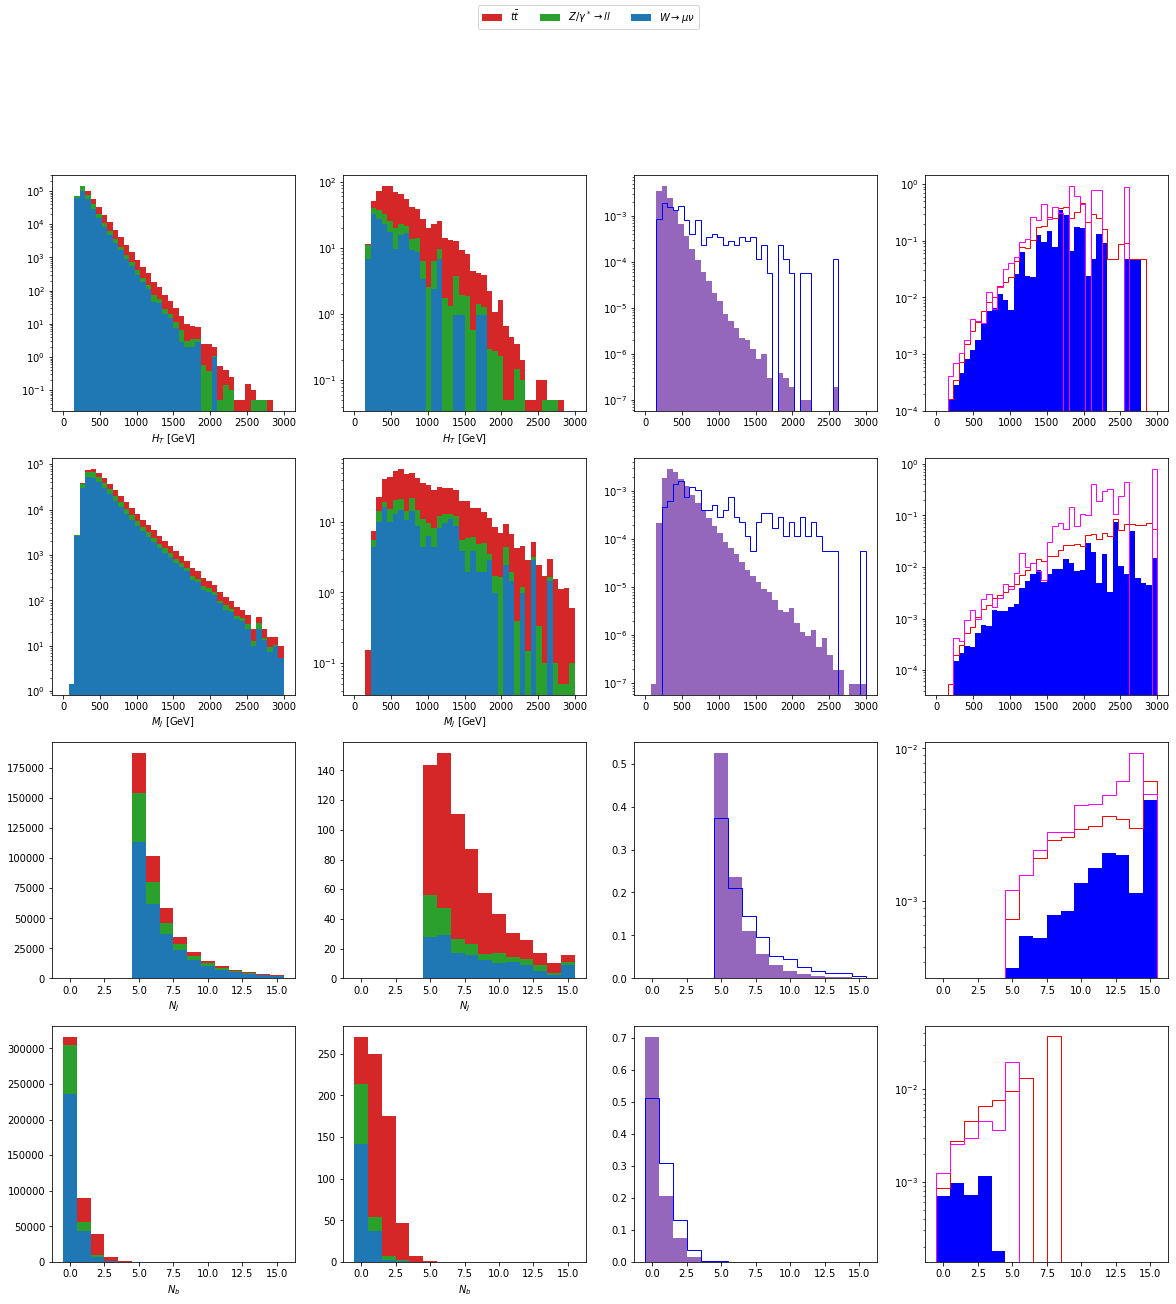

In [134]:
feature_list = ['HT', 'mass_jet', 'n_jet', 'n_bjet']
background_plot_list = ['W', 'DY', 'ttbar']

plot_size = 5

color_dict = {}
color_dict['W']='tab:blue'
color_dict['DY']='tab:green'
color_dict['ttbar']='tab:red'
color_dict['data']='tab:purple'

label_dict = {}
label_dict['W'] = r'$W \rightarrow \mu\nu$'
label_dict['DY'] = r'$Z/\gamma^* \rightarrow ll$'
label_dict['ttbar'] = r'$t\bar{t}$'

all_lin = False

n_features = len(feature_list)
fig, ax_arr = plt.subplots(n_features, 4, figsize=(4 * plot_size, n_features * plot_size))

for row, feature in enumerate(feature_list):
    f_setting = hist_settings[feature]
    
    # col 0, 1
    for col, cut in enumerate(['hist_pre', 'hist_ano']):
        ax = ax_arr[row, col]
    
        # plot background stacked
        x_list = []
        bin_edges = None
        weights_list = []
        color_list = []
        label_list = []
        
        for proc in background_plot_list:
            hist = hist_cut_proc_dict[cut][proc]
            bin_edges = hist[feature].bin_edges
            x_list.append(hist[feature].bin_edges[:-1])
            weights_list.append(hist[feature].bin_content)
            color_list.append(color_dict[proc])
            label_list.append(label_dict[proc])
            
        ax.hist(x_list, bin_edges, weights=weights_list, 
                stacked=True, histtype='stepfilled', color=color_list, label=label_list)
        
        # axis settings
        if all_lin is False:
            ax.set_yscale(f_setting['yscale'])
            
        ax.set_xlabel(f_setting['symbol'])

    # col 2
    ax = ax_arr[row, 2]
    
    # plot data
    hist_data_f = hist_cut_proc_dict['hist_pre']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='stepfilled', density=True,color=color_dict['data'], label='data')
    
    # plot data anomalous
    hist_data_f = hist_cut_proc_dict['hist_ano']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='step', color='b', label='data a', density=True)

    # axis settings
    if all_lin is False:
        ax.set_yscale(f_setting['yscale'])

# fix ppm
# uncertainty (opt)

# plot ADSE
for row, feature in enumerate(feature_list):
    ax = ax_arr[row, 3]
    f_setting = hist_settings[feature]
    
    bin_edges = hist_amp_dict['b'][feature].bin_edges
    bin_content = hist_amp_dict['b'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='stepfilled',# density=True,
            label='background', color='blue')

    bin_edges = hist_amp_dict['bs'][feature].bin_edges
    bin_content = hist_amp_dict['bs'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
            label='W+DY+tt', color='red')
    
    bin_edges = hist_amp_dict['data'][feature].bin_edges
    bin_content = hist_amp_dict['data'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
            label='W+DY+tt', color='magenta')

    # bin_edges = hist_amp_dict['data'][feature].bin_edges
    # bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    # bin_content = hist_amp_dict['data'][feature].bin_content
    # ax.plot(bin_centers, bin_content, 'bo', label='data')
    
    ax.set_yscale('log')

handles, labels = ax_arr[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)
# fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#         mode="expand", borderaxespad=0.)


plt.savefig('figures/adse.pdf')
plt.show()

In [135]:
#plots
# mc detailed no stack

# data vs mc (after cuts)

# data_a vs mc_a (with ppm fixed) (with ad trained on clean mc)

# amplification 

# normal and anomalous b=0,1

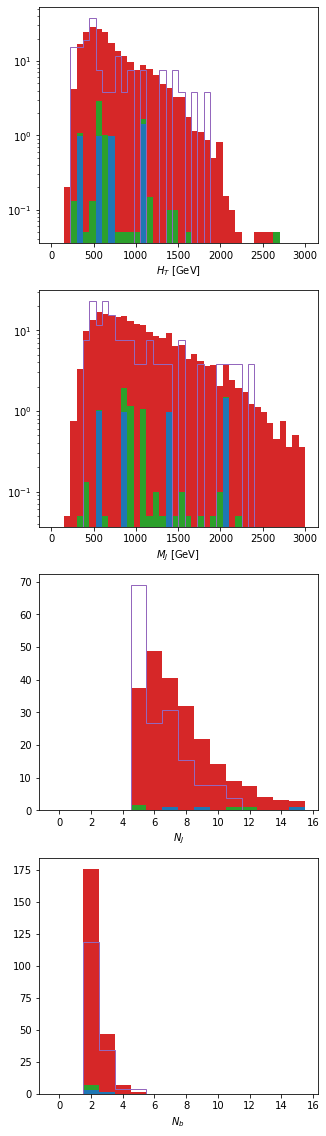

In [136]:
fig, ax_arr = plt.subplots(n_features, 1, figsize=(1 * plot_size, n_features * plot_size))
background_plot_list = ['W', 'DY', 'ttbar']
for row, feature in enumerate(feature_list):
    f_setting = hist_settings[feature]
 

    ax = ax_arr[row]
    
    # plot background stacked
    x_list = []
    bin_edges = None
    weights_list = []
    color_list = []
    label_list = []
    
    for proc in background_plot_list:
        hist = hist_cut_proc_dict['hist_pos'][proc]
        bin_edges = hist[feature].bin_edges
        x_list.append(hist[feature].bin_edges[:-1])
        weights_list.append(hist[feature].bin_content)
        color_list.append(color_dict[proc])
        label_list.append(label_dict[proc])
        
    ax.hist(x_list, bin_edges, weights=weights_list, 
            stacked=True, histtype='stepfilled', color=color_list, label=label_list, density=False)
    
    hist_data_f = hist_cut_proc_dict['hist_pos']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='step', density=False, color=color_dict['data'], label='data')
    
    
    # axis settings
    if all_lin is False:
        ax.set_yscale(f_setting['yscale'])
        
    ax.set_xlabel(f_setting['symbol'])

    
plt.show()